In [1]:
# Basic Imports
import pandas as pd  
import numpy as np
import seaborn as sns
import string
import re

# Plotting Imports
from plotnine import *
import matplotlib.pyplot as plt

# Utility Imports
import re
from wordcloud import WordCloud 
import nltk
nltk.download('stopwords')
import sklearn.metrics as metrics
from nltk import word_tokenize
from nltk.corpus import stopwords # remove stopwords (and punctuations) such as the, a etc. (as they do not provide any info as to whether or not the news is positive or negative)
from nltk.stem import WordNetLemmatizer # change all the words to stem words (eg loved or loves to love)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error, roc_curve, accuracy_score, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score, f1_score

# Text-Vector Imports
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier

In [169]:
# data
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [170]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [171]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Data Cleaning and Pre-Processing

In [172]:
fake['label'] = 0
true['label'] = 1

# concat both datasets into 1, with fake being labelled 0 and true being labelled 1
news = pd.concat([fake, true]).reset_index(drop = True)
news.head()

# 44898 rows

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Drop rows with empty titles and texts

In [173]:
#Those with empty text
news[news.text == ' '].groupby('label').label.count()

news[news.text == '  '].groupby('label').label.count()

label
0    4
Name: label, dtype: int64

In [174]:
news = news[news.text != ' ']

news = news[news.text != '  ']

# 627 rows removed

### Types of subjects

In [123]:
news.groupby(['label', 'subject']).subject.count()

label  subject        
0      Government News     1499
       Middle-east          778
       News                9050
       US_News              783
       left-news           4310
       politics            6435
1      politicsNews       11271
       worldnews          10145
Name: subject, dtype: int64

### Proportion of fake and true news

<AxesSubplot:xlabel='label', ylabel='count'>

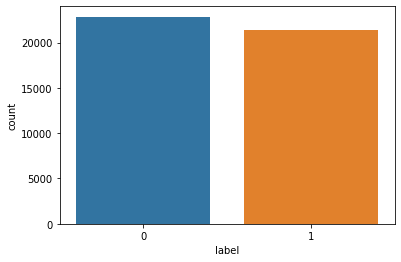

In [124]:
sns.countplot(x='label', data=news)

In [125]:
news.groupby('label').label.count()

# true news starts from index 22845

label
0    22855
1    21416
Name: label, dtype: int64

### Further cleaning for wordclouds

In [129]:
true_cleaned = news[news["label"]==1]
fake_cleaned = news[news["label"]==0]

In [127]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44271 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44271 non-null  object
 1   text     44271 non-null  object
 2   subject  44271 non-null  object
 3   date     44271 non-null  object
 4   label    44271 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


In [130]:
true_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21416 entries, 23481 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21416 non-null  object
 1   text     21416 non-null  object
 2   subject  21416 non-null  object
 3   date     21416 non-null  object
 4   label    21416 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1003.9+ KB


In [15]:
fake_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22855 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    22855 non-null  object
 1   text     22855 non-null  object
 2   subject  22855 non-null  object
 3   date     22855 non-null  object
 4   label    22855 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


# Title and Text Cleaning 

## Clean with source present 

### Fake News

In [133]:
# \W matching non-alphanumeric character ie. [^a-zA-Z0-9_]

def preprocess(row, col, cleanedlist):
    new = re.sub('\W+', ' ', row[col]) # replace punctuations/ non-alphanumeric characters by spaces so words aren't stuck together
    
    new = new.lower() # change all capital letters to lower case
    
    new = new.split() # split strings into a list of words
    
    new = ' '.join(new)
    
    cleanedlist.append(new)

In [134]:
fake_title_cleaned = [] # add cleaned titles here
fake_text_cleaned = [] # add cleaned texts here

In [135]:
fake_cleaned.apply(lambda row: preprocess(row, 'title', fake_title_cleaned), axis=1);

In [136]:
fake_cleaned.apply(lambda row: preprocess(row, 'text', fake_text_cleaned), axis=1);

### True News

In [24]:
true_title_cleaned = [] # add cleaned titles here
true_text_cleaned = [] # add cleaned texts here

In [25]:
true_cleaned.apply(lambda row: preprocess(row, 'title', true_title_cleaned), axis=1);

In [26]:
true_cleaned.apply(lambda row: preprocess(row, 'text', true_text_cleaned), axis=1);

### Lemmatizations

In [226]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
for i in range(len(fake_title_cleaned)):
    tokens = word_tokenize(fake_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_title_cleaned[i] = " ".join(lemmatized)

In [ ]:
for i in range(len(fake_text_cleaned)):
    tokens = word_tokenize(fake_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_text_cleaned[i] = " ".join(lemmatized)

In [ ]:
for i in range(len(true_title_cleaned)):
    tokens = word_tokenize(true_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_title_cleaned[i] = " ".join(lemmatized)

In [ ]:
for i in range(len(true_text_cleaned)):
    tokens = word_tokenize(true_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_text_cleaned[i] = " ".join(lemmatized)

In [ ]:
final_title = []
final_title.extend(fake_title_cleaned)
final_title.extend(true_title_cleaned)

In [ ]:
final_text = []
final_text.extend(fake_text_cleaned)
final_text.extend(true_text_cleaned)

In [ ]:
final_df = pd.concat([pd.DataFrame(final_title), pd.DataFrame(final_text), news['label']], axis = 1)

final_df.columns = ['title', 'text', 'label']

final_df = final_df[final_df.text.isna() == False].reset_index().drop(['index', 'Unnamed: 0'], axis = 1) #to remove the rows with empty texts

final_df.to_csv("news_final.csv")

## Remove source

In [258]:
true_cleaned = news[news["label"]==1]
fake_cleaned = news[news["label"]==0]

In [260]:
# \W matching non-alphanumeric character ie. [^a-zA-Z0-9_]

def preprocess(row, col, cleanedlist):
    new = re.sub('\W+', ' ', row[col]) # replace punctuations/ non-alphanumeric characters by spaces so words aren't stuck together
    
    new = new.lower() # change all capital letters to lower case
    
    new = new.split() # split strings into a list of words
    
    new = ' '.join(new)
    
    cleanedlist.append(new)

In [261]:
fake_title_cleaned = [] # add cleaned titles here
fake_text_cleaned = [] # add cleaned texts here

In [262]:
fake_cleaned.apply(lambda row: preprocess(row, 'title', fake_title_cleaned), axis=1);

In [265]:
fake_cleaned.apply(lambda row: preprocess(row, 'text', fake_text_cleaned), axis=1);

In [266]:
true_title_cleaned = [] # add cleaned titles here
true_text_cleaned = [] # add cleaned texts here

In [267]:
true_cleaned.apply(lambda row: preprocess(row, 'title', true_title_cleaned), axis=1);

In [268]:
true_cleaned.apply(lambda row: preprocess(row, 'text', true_text_cleaned), axis=1);

In [269]:
for i in range(len(fake_title_cleaned)):
    tokens = word_tokenize(fake_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_title_cleaned[i] = " ".join(lemmatized)

In [270]:
for i in range(len(fake_text_cleaned)):
    tokens = word_tokenize(fake_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_text_cleaned[i] = " ".join(lemmatized)

In [271]:
for i in range(len(true_title_cleaned)):
    tokens = word_tokenize(true_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_title_cleaned[i] = " ".join(lemmatized)

In [272]:
for i in range(len(true_text_cleaned)):
    tokens = word_tokenize(true_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_text_cleaned[i] = " ".join(lemmatized)

In [296]:
final_title = []
final_title.extend(fake_title_cleaned)
final_title.extend(true_title_cleaned)

In [297]:
final_text = []
final_text.extend(fake_text_cleaned)
final_text.extend(true_text_cleaned)

In [298]:
def removeSource(text):
    arr = text.split('reuters', 1)
    if len(arr) > 1:
        if arr[1] == "":
            return arr[0].strip()
        return arr[1].strip()
    else:
        return text

In [356]:
final_df = pd.concat([pd.DataFrame(final_title), pd.DataFrame(final_text)], axis = 1)

final_df.columns = ['title', 'text']

final_df['label'] = news['label'].values

final_df['text'] = final_df['text'].apply(lambda x: removeSource(x))

In [358]:
final_df

,title,text,label
0,donald trump sends out embarrassing new year s...,donald trump just couldn t wish all american a...,0
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,0
2,sheriff david clarke becomes an internet joke ...,on friday it wa revealed that former milwaukee...,0
3,trump is so obsessed he even ha obama s name c...,on christmas day donald trump announced that h...,0
4,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,0
...,...,...,...
44262,fully committed nato back new u s approach on ...,nato ally on tuesday welcomed president donald...,1
44263,lexisnexis withdrew two product from chinese m...,lexisnexis a provider of legal regulatory and ...,1
44264,minsk cultural hub becomes haven from authority,in the shadow of disused soviet era factory in...,1
44265,vatican upbeat on possibility of pope francis ...,vatican secretary of state cardinal pietro par...,1


In [359]:
final_df.to_csv("SR_combined.csv")

## Truncate Text

In [360]:
true_cleaned = news[news["label"]==1]
fake_cleaned = news[news["label"]==0]


# \W matching non-alphanumeric character ie. [^a-zA-Z0-9_]
def preprocess(row, col, cleanedlist):
    new = re.sub('\W+', ' ', row[col]) # replace punctuations/ non-alphanumeric characters by spaces so words aren't stuck together
    
    new = new.lower() # change all capital letters to lower case
    
    new = new.split() # split strings into a list of words
    
    new = ' '.join(new)
    
    cleanedlist.append(new)

In [361]:
fake_title_cleaned = [] # add cleaned titles here
fake_text_cleaned = [] # add cleaned texts here

In [362]:
fake_cleaned.apply(lambda row: preprocess(row, 'title', fake_title_cleaned), axis=1);

In [363]:
fake_cleaned.apply(lambda row: preprocess(row, 'text', fake_text_cleaned), axis=1);

In [364]:
true_title_cleaned = [] # add cleaned titles here
true_text_cleaned = [] # add cleaned texts here

In [365]:
true_cleaned.apply(lambda row: preprocess(row, 'title', true_title_cleaned), axis=1);

In [366]:
true_cleaned.apply(lambda row: preprocess(row, 'text', true_text_cleaned), axis=1);

In [367]:
for i in range(len(fake_title_cleaned)):
    tokens = word_tokenize(fake_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_title_cleaned[i] = " ".join(lemmatized)

In [368]:
for i in range(len(fake_text_cleaned)):
    tokens = word_tokenize(fake_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    fake_text_cleaned[i] = " ".join(lemmatized)

In [369]:
for i in range(len(true_title_cleaned)):
    tokens = word_tokenize(true_title_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_title_cleaned[i] = " ".join(lemmatized)

In [370]:
for i in range(len(true_text_cleaned)):
    tokens = word_tokenize(true_text_cleaned[i])
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    true_text_cleaned[i] = " ".join(lemmatized)

In [373]:
final_title = []
final_title.extend(fake_title_cleaned)
final_title.extend(true_title_cleaned)

In [374]:
final_text = []
final_text.extend(fake_text_cleaned)
final_text.extend(true_text_cleaned)

In [375]:
final_df = pd.concat([pd.DataFrame(final_title), pd.DataFrame(final_text)], axis = 1)

final_df.columns = ['title', 'text']

final_df['label'] = news['label'].values

final_df = final_df[final_df.text.isna() == False].reset_index().drop('index', axis = 1) #to remove the rows with empty texts

final_df['text'] = final_df['text'].apply(lambda x: removeSource(x))

def truncate(text):
    arr = text.split()
    if (len(arr) > 150):
        a = arr[:150]
        return ' '.join(a)
    else:
        return text
    
final_df['text'] = final_df['text'].apply(lambda x: truncate(x))

In [378]:
final_df.to_csv("truncated.csv")

# WordClouds

In [ ]:
def preprocess(row, col, cleanedlist): # for fake news
    cleanedlist.append(row[col])

In [ ]:
truncated = pd.read_csv('truncated_combined.csv')

truncated_title_f = []
truncated_title_t = []

tf = truncated[truncated['label'] == 0]
tt = truncated[truncated['label'] == 1]
tf.apply(lambda row: preprocess(row, 'title', truncated_title_f), axis=1);
tt.apply(lambda row: preprocess(row, 'title', truncated_title_t), axis=1);

truncated_titles_f = (" ").join(truncated_title_f)
truncated_titles_t = (" ").join(truncated_title_t) # 'word ' for true vs 'word' for f

truncated_titles = (truncated_titles_f + truncated_titles_t).split()
truncated_titles = ' '.join(truncated_titles)

def colour_func_true(word, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    return '#00ff00'

def colour_func_false(word, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    return '#ff0000'

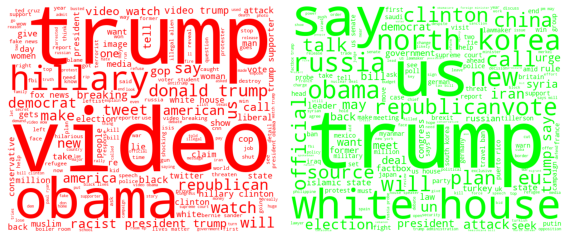

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(titles_false_wc)
axes[0].axis('off')
axes[1].imshow(titles_true_wc)
axes[1].axis('off')
fig.tight_layout();

In [42]:
truncated_text_f = []
truncated_text_t = []

trunc = truncated[~truncated['text'].isnull()]
tf = trunc[trunc['label'] == 0]
tt = trunc[trunc['label'] == 1]
tf.apply(lambda row: preprocess(row, 'text', truncated_text_f), axis=1);
tt.apply(lambda row: preprocess(row, 'text', truncated_text_t), axis=1);

truncated_texts_f = (" ").join(truncated_text_f)
truncated_texts_t = (" ").join(truncated_text_t) # 'word ' for true vs 'word' for f

truncated_texts = (truncated_texts_f + truncated_texts_t).split()
truncated_texts = ' '.join(truncated_texts)

In [43]:
texts_false_wc = WordCloud(width = 600, height = 500, color_func = colour_func_false, background_color = 'white').generate(truncated_texts_f)
texts_true_wc = WordCloud(width = 600, height = 500, color_func = colour_func_true, background_color = 'white').generate(truncated_texts_t)

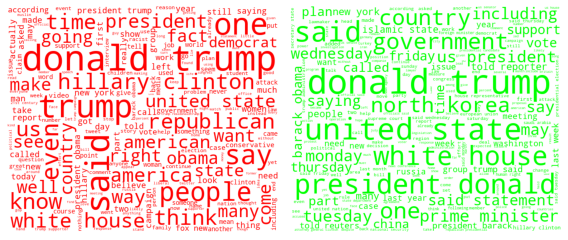

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(texts_false_wc)
axes[0].axis('off')
axes[1].imshow(texts_true_wc)
axes[1].axis('off')
fig.tight_layout();